# How to read data from BigQuery

This notebook demonstrates two ways to use BigQuery with R
1. by using SQL
2. by using only R code to extract the data of interest from BigQuery

## Setup

In [1]:
lapply(c('skimr'),
       function(pkg) { if(! pkg %in% installed.packages()) { install.packages(pkg)} } )

Installing package into ‘/home/jupyter-user/notebooks/packages’
(as ‘lib’ is unspecified)



[[1]]
NULL

In [2]:
# Load the libraries into memory
library(bigrquery)
library(dplyr)
library(skimr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')

## Retrieve filtered data.
Let’s retrieve a subset of fields and samples in metadata for [1000 Genomes](http://www.internationalgenome.org/data "1000 Genomes").

We can do this in two different ways and they both return the exact same results

1. using SQL and bigrquery
2. using dplyr and dbplyr

### Option 1: Retrieve filtered data from BigQuery using bigrquery.
To learn more about SQL syntax see the [BigQuery standard SQL reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/).

In [4]:
# Run a query 
phase1_samples_tbl <- bigrquery::bq_project_query(
    BILLING_PROJECT_ID,
    query = '
SELECT
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
WHERE
  -- Only include information for samples in phase 1.
  In_Phase1_Integrated_Variant_Set = TRUE
  -- Only include information for samples with these relationships.
  AND Relationship IN ("", "unrel", "child", "father", "mother",
  "mat grandmother", "pat grandmother",
  "mat grandfather", "pat grandfather")
')

phase1_samples <- bigrquery::bq_table_download(phase1_samples_tbl)

In [5]:
dim(phase1_samples)

[1] 1086   10

In [6]:
print(skim(phase1_samples))

── Data Summary ────────────────────────
                           Values        
Name                       phase1_samples
Number of rows             1086          
Number of columns          10            
_______________________                  
Column type frequency:                   
  character                9             
  numeric                  1             
________________________                 
Group variables            None          

── Variable type: character ────────────────────────────────────────────────────
  skim_variable                n_missing complete_rate   min   max empty
1 Sample                               0             1     7     7     0
2 Gender                               0             1     4     6     0
3 Relationship                         0             1     0    15   559
4 Population                           0             1     3     3     0
5 Population_Description               0             1    16    58     0
6 Super_Population 

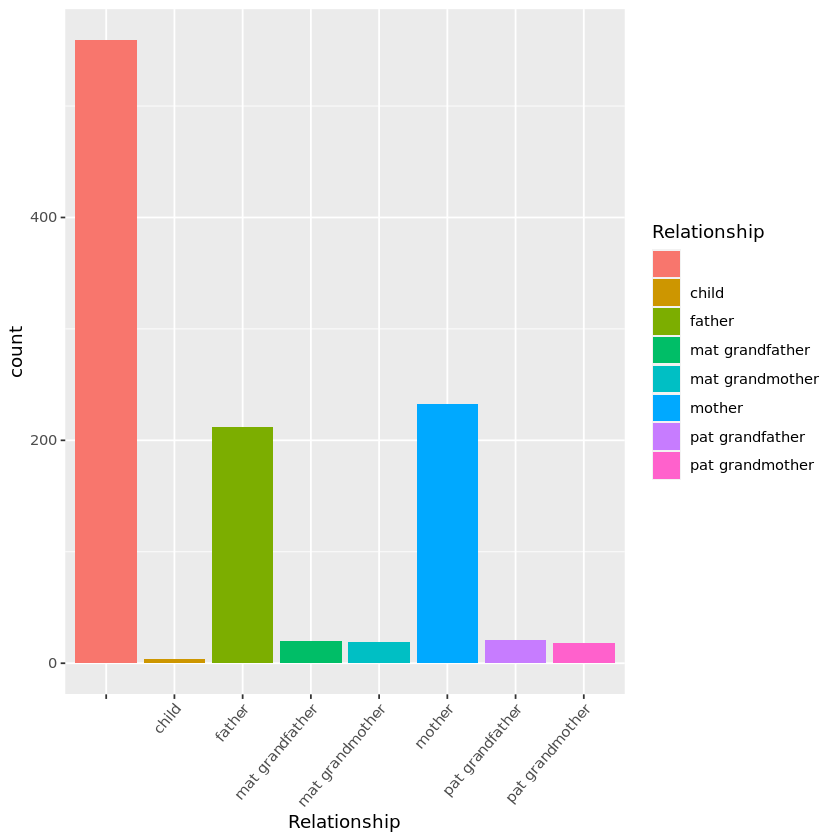

In [7]:
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

### Option 2: Retrieve filtered data from BigQuery using dplyr.
To learn more about dplyr see [R for Data Science Chapter 5 Data transformation](http://r4ds.had.co.nz/transform.html "Chapter 5").

In [8]:
# Create a "connection" to a public BigQuery dataset.
dbcon <- bigrquery::src_bigquery(project = 'bigquery-public-data',
                                 dataset = 'human_genome_variants',
                                 billing = BILLING_PROJECT_ID)

# Create a 'virtual dataframe' backed by a BigQuery table.
sample_info <- dplyr::tbl(dbcon, '1000_genomes_sample_info')

In [9]:
phase1_only <- sample_info %>% filter(
    In_Phase1_Integrated_Variant_Set == TRUE,
    Relationship %in% c(
      '', 'unrel', 'child', 'father', 'mother',
      'mat grandmother', 'pat grandmother',
      'mat grandfather', 'pat grandfather')
  )
# Nothing is computed on BigQuery yet.

In [10]:
sample_fields <- phase1_only %>% select(
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
  )
# Still nothing computed on BigQuery.

In [11]:
# Optional: take a look at the SQL.
dplyr::show_query(sample_fields)

<SQL>
SELECT `Sample`, `Gender`, `Relationship`, `Population`, `Population_Description`, `Super_Population`, `Super_Population_Description`, `Total_Exome_Sequence`, `Main_Project_E_Platform`, `Main_Project_E_Centers`
FROM `1000_genomes_sample_info`
WHERE ((`In_Phase1_Integrated_Variant_Set` = TRUE) AND (`Relationship` IN ('', 'unrel', 'child', 'father', 'mother', 'mat grandmother', 'pat grandmother', 'mat grandfather', 'pat grandfather')))


In [12]:
# Optional: See how much data this will return.
sample_fields %>% summarize(cnt = n()) %>% collect()

cnt
<int>
1086


In [13]:
# Execute the query and return all results into an in-memory table in R.
phase1_samples <- sample_fields %>% collect()

In [14]:
dim(phase1_samples)

[1] 1086   10

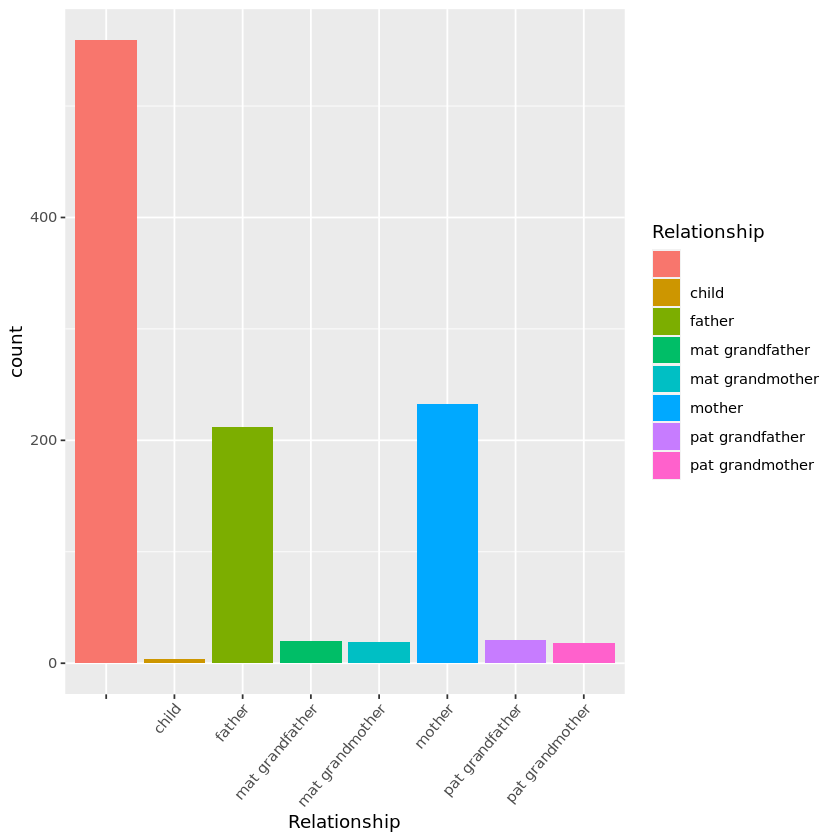

In [15]:
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

# Provenance

In [16]:
devtools::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.5 (2021-03-31)
 os       Ubuntu 18.04.5 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2021-05-19                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version date       lib source        
 assertthat    0.2.1   2019-03-21 [2] CRAN (R 4.0.5)
 base64enc     0.1-3   2015-07-28 [2] CRAN (R 4.0.5)
 bigrquery   * 1.3.2   2020-10-05 [2] CRAN (R 4.0.5)
 bit           4.0.4   2020-08-04 [2] CRAN (R 4.0.5)
 bit64         4.0.5   2020-08-30 [2] CRAN (R 4.0.5)
 blob          1.2.1   2020-01-20 [2] CRAN (R 4.0.5)
 cachem        1.0.4   2021-02-13 [2] CRAN (R 4.0.5)
 callr         3.7.0   2021

Copyright 2018 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.